In [2]:
import pandas as pd
import numpy as np
import sqlite3
from google.colab import files

uploaded = files.upload()

Saving BNB Historical Data.csv to BNB Historical Data.csv
Saving XRP Historical Data.csv to XRP Historical Data.csv
Saving Ethereum Historical Data.csv to Ethereum Historical Data.csv
Saving BTC_USD Bitfinex Historical Data.csv to BTC_USD Bitfinex Historical Data.csv


In [4]:


# ===============================
# 2️⃣ Load & Clean Data
# ===============================
def load_crypto(file_path, crypto_name):
    df = pd.read_csv(file_path, usecols=["Date", "Price"])
    df["Date"] = pd.to_datetime(df["Date"])
    df.sort_values("Date", inplace=True)
    df.reset_index(drop=True, inplace=True)
    # Remove commas and convert to float
    df["Price"] = df["Price"].astype(str).str.replace(",", "", regex=False).astype(float)
    df.rename(columns={"Price": f"{crypto_name}_Price"}, inplace=True)
    return df

btc = load_crypto("BTC_USD Bitfinex Historical Data.csv", "BTC")
eth = load_crypto("Ethereum Historical Data.csv", "ETH")
bnb = load_crypto("BNB Historical Data.csv", "BNB")
xrp = load_crypto("XRP Historical Data.csv", "XRP")

# ===============================
# 3️⃣ Metric Functions
# ===============================
def percent_change(prices):
    changes = [0]  # first day
    for i in range(1, len(prices)):
        changes.append(round((prices[i] - prices[i-1]) / prices[i-1] * 100, 2))
    return changes

def moving_average(prices, window=3):
    sma = []
    for i in range(len(prices)):
        if i < window-1:
            sma.append(round(np.mean(prices[:i+1]), 2))
        else:
            sma.append(round(np.mean(prices[i-window+1:i+1]), 2))
    return sma

def calculate_volatility(prices):
    changes = percent_change(prices)[1:]  # skip first
    return [round(np.std(changes), 2)] * len(prices)  # same value for all rows

def trading_signal(prices):
    changes = percent_change(prices)
    signals = []
    for change in changes:
        if change > 2:
            signals.append("BUY")
        elif change < -2:
            signals.append("SELL")
        else:
            signals.append("HOLD")
    return signals

def portfolio_return(assetA, assetB, wA=0.6, wB=0.4):
    returns = []
    for a, b in zip(assetA, assetB):
        returns.append(round(wA*a + wB*b, 2))
    return returns

# ===============================
# 4️⃣ Apply Metrics to Each Crypto
# ===============================
def compute_metrics(df, crypto_name):
    prices = df[f"{crypto_name}_Price"].tolist()
    metrics = pd.DataFrame({
        "Date": df["Date"],
        f"{crypto_name}_Price": prices,
        f"{crypto_name}_Return": percent_change(prices),
        f"{crypto_name}_3D_MA": moving_average(prices, window=3),
        f"{crypto_name}_30D_MA": moving_average(prices, window=30),
        f"{crypto_name}_Volatility": calculate_volatility(prices),
        f"{crypto_name}_Signal": trading_signal(prices)
    })
    return metrics

btc_metrics = compute_metrics(btc, "BTC")
eth_metrics = compute_metrics(eth, "ETH")
bnb_metrics = compute_metrics(bnb, "BNB")
xrp_metrics = compute_metrics(xrp, "XRP")

# ===============================
# 5️⃣ Combine All Metrics
# ===============================
# Merge on Date
crypto_combined = btc_metrics.merge(eth_metrics, on="Date", how="inner")\
                             .merge(bnb_metrics, on="Date", how="inner")\
                             .merge(xrp_metrics, on="Date", how="inner")

# ===============================
# 6️⃣ Portfolio Return Example (BTC + ETH)
# ===============================
crypto_combined["Portfolio_Return"] = portfolio_return(
    crypto_combined["BTC_Return"], crypto_combined["ETH_Return"], wA=0.6, wB=0.4
)

# ===============================
# 7️⃣ Final Cleanup
# ===============================
# Ensure no NaNs (already handled by functions, but just in case)
crypto_combined.fillna(0, inplace=True)

# ===============================
# 8️⃣ Display Results
# ===============================
print("✅ BTC Metrics Sample:")
display(btc_metrics.head())

print("✅ ETH Metrics Sample:")
display(eth_metrics.head())

print("✅ Combined Metrics & Portfolio Sample:")
display(crypto_combined.head())

# ===============================
# 9️⃣ Save to CSV
# ===============================
crypto_combined.to_csv("crypto_metrics_full.csv", index=False)
print("💾 Saved as 'crypto_metrics_full.csv'")


✅ BTC Metrics Sample:


,Date,BTC_Price,BTC_Return,BTC_3D_MA,BTC_30D_MA,BTC_Volatility,BTC_Signal
0,2023-08-29,27752.0,0.00,27752.00,27752.00,2.49,HOLD
1,2023-08-30,27325.0,-1.54,27538.50,27538.50,2.49,HOLD
2,2023-08-31,25967.0,-4.97,27014.67,27014.67,2.49,SELL
3,2023-09-01,25816.0,-0.58,26369.33,26715.00,2.49,HOLD
4,2023-09-02,25870.0,0.21,25884.33,26546.00,2.49,HOLD


✅ ETH Metrics Sample:


,Date,ETH_Price,ETH_Return,ETH_3D_MA,ETH_30D_MA,ETH_Volatility,ETH_Signal
0,2023-08-29,1729.69,0.00,1729.69,1729.69,3.54,HOLD
1,2023-08-30,1705.22,-1.41,1717.46,1717.46,3.54,HOLD
2,2023-08-31,1645.82,-3.48,1693.58,1693.58,3.54,SELL
3,2023-09-01,1629.00,-1.02,1660.01,1677.43,3.54,HOLD
4,2023-09-02,1637.05,0.49,1637.29,1669.36,3.54,HOLD


✅ Combined Metrics & Portfolio Sample:


,Date,BTC_Price,BTC_Return,BTC_3D_MA,BTC_30D_MA,BTC_Volatility,BTC_Signal,ETH_Price,ETH_Return,ETH_3D_MA,...,BNB_30D_MA,BNB_Volatility,BNB_Signal,XRP_Price,XRP_Return,XRP_3D_MA,XRP_30D_MA,XRP_Volatility,XRP_Signal,Portfolio_Return
0,2025-07-29,118110.0,-0.06,118626.67,115045.00,2.49,HOLD,3793.94,-0.08,3820.86,...,805.40,2.58,HOLD,3.1281,0.19,3.16,2.85,4.28,HOLD,-0.07
1,2025-07-30,118050.0,-0.05,118113.33,115405.00,2.49,HOLD,3808.91,0.39,3799.92,...,799.40,2.58,HOLD,3.0958,-1.03,3.12,2.87,4.28,HOLD,0.13
2,2025-07-31,115970.0,-1.76,117376.67,115740.00,2.49,HOLD,3698.46,-2.90,3767.10,...,794.00,2.58,HOLD,3.0216,-2.40,3.08,2.90,4.28,SELL,-2.22
3,2025-08-01,113500.0,-2.13,115840.00,115890.67,2.49,SELL,3488.36,-5.68,3665.24,...,784.80,2.58,SELL,2.9608,-2.01,3.03,2.93,4.28,SELL,-3.55
4,2025-08-02,112810.0,-0.61,114093.33,115992.33,2.49,HOLD,3393.92,-2.71,3526.91,...,775.18,2.58,SELL,2.7694,-6.46,2.92,2.94,4.28,SELL,-1.45


💾 Saved as 'crypto_metrics_full.csv'


In [5]:
# =======================
# 2. Load datasets
# =======================
def load_data(uploaded_files):
    dfs = []
    for fname in uploaded_files.keys():
        df = pd.read_csv(fname)
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        df = df.dropna(subset=['Date'])

        # Detect price column
        price_cols = [c for c in df.columns if c.lower() in ['close', 'adj close', 'price']]
        if not price_cols:
            price_col = df.columns[1]  # fallback
        else:
            price_col = price_cols[0]

        # Clean numbers
        df[price_col] = pd.to_numeric(
            df[price_col].astype(str).str.replace(',', '').str.replace('%', ''),
            errors='coerce'
        )

        df = df[['Date', price_col]].dropna()

        # Rename column as coin ticker
        fname_lower = fname.lower()
        if "btc" in fname_lower:
            coin = "BTC"
        elif "eth" in fname_lower:
            coin = "ETH"
        elif "xrp" in fname_lower:
            coin = "XRP"
        elif "bnb" in fname_lower:
            coin = "BNB"
        else:
            coin = fname.split('.')[0]

        df = df.rename(columns={price_col: coin})
        dfs.append(df.set_index('Date'))

    prices = pd.concat(dfs, axis=1).dropna()
    return prices

prices = load_data(uploaded)
print("✅ Coins loaded:", prices.columns.tolist())

# =======================
# 3. Compute daily returns
# =======================
returns = prices.pct_change().dropna()

# =======================
# 4. Assign Weights - All Strategies
# =======================
coins = prices.columns

# (a) Equal Weighting
weights_equal = pd.Series(1/len(coins), index=coins)

# (b) Risk-based (inverse volatility)
vol = returns.std() * np.sqrt(252)  # annualized volatility
inv_vol = 1 / vol
weights_risk = inv_vol / inv_vol.sum()

# (c) Market-cap weighting (example values, update if needed)
market_caps = {
    'BTC': 800_000_000_000,
    'ETH': 350_000_000_000,
    'BNB': 40_000_000_000,
    'XRP': 20_000_000_000
}
mc_series = pd.Series(market_caps)
weights_mc = mc_series / mc_series.sum()

# (d) Investment-goal (Balanced Preset)
weights_goal = pd.Series({
    'BTC': 0.5,
    'ETH': 0.25,
    'XRP': 0.15,
    'BNB': 0.10
})

# =======================
# 5. Cap weights (max 0.5) and normalize
# =======================
def cap_weights(weights, cap=0.5):
    w = weights.copy()
    # Cap any weight above 0.5
    w = w.clip(upper=cap)
    # Renormalize so total = 1
    w = w / w.sum()
    return w

# =======================
# 6. Rule Check
# =======================
def check_rule(weights):
    if "BTC" in weights.index and "XRP" in weights.index and "BNB" in weights.index:
        btc_w = weights.get("BTC", 0)
        risky_w = max(weights.get("XRP", 0), weights.get("BNB", 0))
        if btc_w > risky_w:
            return "✅ Rule satisfied: BTC > Risky coins"
        else:
            return "❌ Rule violated: BTC not > Risky coins"
    return "Rule check not applicable"

# =======================
# 7. Portfolio Metrics
# =======================
def portfolio_performance(weights, returns):
    port_ret = (returns @ weights).mean() * 252          # annualized return
    port_vol = (returns @ weights).std() * np.sqrt(252)  # annualized volatility
    return port_ret, port_vol

# =======================
# 8. Display Results (Only Return & Risk)
# =======================
strategies = {
    "Equal": cap_weights(weights_equal),
    "Risk-based": cap_weights(weights_risk),
    "Market-cap": cap_weights(weights_mc),
    "Investment-goal": cap_weights(weights_goal)
}

for name, w in strategies.items():
    r, v = portfolio_performance(w, returns)  # only return & risk
    print(f"\n{name} Strategy:")
    print(f"Weights (capped at 0.5):\n{w.round(3)}")
    print("Rule check:", check_rule(w))
    print(f"Portfolio Return: {r:.2%}, Portfolio Risk (Vol): {v:.2%}")


✅ Coins loaded: ['BNB', 'XRP', 'ETH', 'BTC']

Equal Strategy:
Weights (capped at 0.5):
BNB    0.25
XRP    0.25
ETH    0.25
BTC    0.25
dtype: float64
Rule check: ❌ Rule violated: BTC not > Risky coins
Portfolio Return: 39.89%, Portfolio Risk (Vol): 49.04%

Risk-based Strategy:
Weights (capped at 0.5):
BNB    0.268
XRP    0.172
ETH    0.146
BTC    0.413
dtype: float64
Rule check: ✅ Rule satisfied: BTC > Risky coins
Portfolio Return: 20.21%, Portfolio Risk (Vol): 41.57%

Market-cap Strategy:
Weights (capped at 0.5):
BTC    0.596
ETH    0.345
BNB    0.039
XRP    0.020
dtype: float64
Rule check: ✅ Rule satisfied: BTC > Risky coins
Portfolio Return: 34.02%, Portfolio Risk (Vol): 43.14%

Investment-goal Strategy:
Weights (capped at 0.5):
BTC    0.50
ETH    0.25
XRP    0.15
BNB    0.10
dtype: float64
Rule check: ✅ Rule satisfied: BTC > Risky coins
Portfolio Return: 22.29%, Portfolio Risk (Vol): 43.44%


In [6]:
import sqlite3
import os

# =======================
# 1. Remove old DB file (ensures no old tables conflict)
# =======================
db_path = "portfolio.db"
if os.path.exists(db_path):
    os.remove(db_path)
    print("Old portfolio.db removed!")

# =======================
# 2. Connect to new SQLite DB
# =======================
conn = sqlite3.connect(db_path)
cur = conn.cursor()

# =======================
# 3. Create Tables
# =======================
# Portfolio summary table
cur.execute("""
CREATE TABLE portfolio (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    strategy TEXT,
    annual_return REAL,
    risk REAL
)
""")

# Portfolio-assets table (horizontal schema)
cur.execute("""
CREATE TABLE portfolio_assets (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    portfolio_id INTEGER,
    BTC REAL,
    ETH REAL,
    XRP REAL,
    BNB REAL,
    FOREIGN KEY (portfolio_id) REFERENCES portfolio (id)
)
""")
conn.commit()

# =======================
# 4. Insert Data
# =======================
for name, w in strategies.items():
    # Portfolio-level metrics
    r, v = portfolio_performance(w, returns)
    cur.execute("""
        INSERT INTO portfolio (strategy, annual_return, risk)
        VALUES (?, ?, ?)
    """, (name, r, v))

    portfolio_id = cur.lastrowid

    # Asset-level weights (horizontal)
    btc_w = float(w.get('BTC', 0))
    eth_w = float(w.get('ETH', 0))
    xrp_w = float(w.get('XRP', 0))
    bnb_w = float(w.get('BNB', 0))

    cur.execute("""
        INSERT INTO portfolio_assets (portfolio_id, BTC, ETH, XRP, BNB)
        VALUES (?, ?, ?, ?, ?)
    """, (portfolio_id, btc_w, eth_w, xrp_w, bnb_w))

conn.commit()

# =======================
# 5. Fetch Data
# =======================
print("✅ Portfolio Summary Table:\n")
for row in cur.execute("SELECT * FROM portfolio"):
    print(row)

print("\n✅ Portfolio Assets Table (One Row Per Portfolio):\n")
for row in cur.execute("SELECT * FROM portfolio_assets"):
    print(row)

conn.close()


✅ Portfolio Summary Table:

(1, 'Equal', 0.3988559886617809, 0.4904393003960932)
(2, 'Risk-based', 0.20214095076618338, 0.41573641396354366)
(3, 'Market-cap', 0.340221692960723, 0.43141978634140116)
(4, 'Investment-goal', 0.22285030926867289, 0.434397865159719)

✅ Portfolio Assets Table (One Row Per Portfolio):

(1, 1, 0.25, 0.25, 0.25, 0.25)
(2, 2, 0.41335656670652926, 0.14627353105355712, 0.17197273938472288, 0.2683971628551907)
(3, 3, 0.5960591133004927, 0.3448275862068965, 0.019704433497536946, 0.03940886699507389)
(4, 4, 0.5, 0.25, 0.15, 0.1)


In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# =======================
# 1. Function to run a single strategy
# =======================
def run_strategy(name, weights, returns):
    # Cap weights
    w_capped = cap_weights(weights)
    # Portfolio metrics
    r, v = portfolio_performance(w_capped, returns)
    # Rule check
    rule = check_rule(w_capped)
    return name, w_capped, r, v, rule

# =======================
# 2. Run all strategies in parallel
# =======================
results = []

with ThreadPoolExecutor(max_workers=len(strategies)) as executor:
    futures = {executor.submit(run_strategy, name, w, returns): name for name, w in strategies.items()}
    for future in as_completed(futures):
        results.append(future.result())

# =======================
# 3. Save results into DB
# =======================
# Reconnect to DB
conn = sqlite3.connect("portfolio.db")
cur = conn.cursor()

for name, w, r, v, rule in results:
    # Portfolio table
    cur.execute("""
        INSERT INTO portfolio (strategy, annual_return, risk)
        VALUES (?, ?, ?)
    """, (name, r, v))
    portfolio_id = cur.lastrowid

    # Portfolio assets table (horizontal layout)
    btc_w = float(w.get('BTC', 0))
    eth_w = float(w.get('ETH', 0))
    xrp_w = float(w.get('XRP', 0))
    bnb_w = float(w.get('BNB', 0))

    cur.execute("""
        INSERT INTO portfolio_assets (portfolio_id, BTC, ETH, XRP, BNB)
        VALUES (?, ?, ?, ?, ?)
    """, (portfolio_id, btc_w, eth_w, xrp_w, bnb_w))

conn.commit()

# =======================
# 4. Fetch and display saved data
# =======================
print("✅ Portfolio Summary Table After Parallel Execution:\n")
for row in cur.execute("SELECT * FROM portfolio"):
    print(row)

print("\n✅ Portfolio Assets Table After Parallel Execution:\n")
for row in cur.execute("SELECT * FROM portfolio_assets"):
    print(row)

conn.close()


✅ Portfolio Summary Table After Parallel Execution:

(1, 'Equal', 0.3988559886617809, 0.4904393003960932)
(2, 'Risk-based', 0.20214095076618338, 0.41573641396354366)
(3, 'Market-cap', 0.340221692960723, 0.43141978634140116)
(4, 'Investment-goal', 0.22285030926867289, 0.434397865159719)
(5, 'Risk-based', 0.20214095076618338, 0.41573641396354366)
(6, 'Market-cap', 0.42015657602909434, 0.4508033483187285)
(7, 'Equal', 0.3988559886617809, 0.4904393003960932)
(8, 'Investment-goal', 0.22285030926867289, 0.434397865159719)

✅ Portfolio Assets Table After Parallel Execution:

(1, 1, 0.25, 0.25, 0.25, 0.25)
(2, 2, 0.41335656670652926, 0.14627353105355712, 0.17197273938472288, 0.2683971628551907)
(3, 3, 0.5960591133004927, 0.3448275862068965, 0.019704433497536946, 0.03940886699507389)
(4, 4, 0.5, 0.25, 0.15, 0.1)
(5, 5, 0.41335656670652926, 0.14627353105355712, 0.17197273938472288, 0.2683971628551907)
(6, 6, 0.5531335149863761, 0.38147138964577654, 0.021798365122615806, 0.04359673024523161)
(7, 

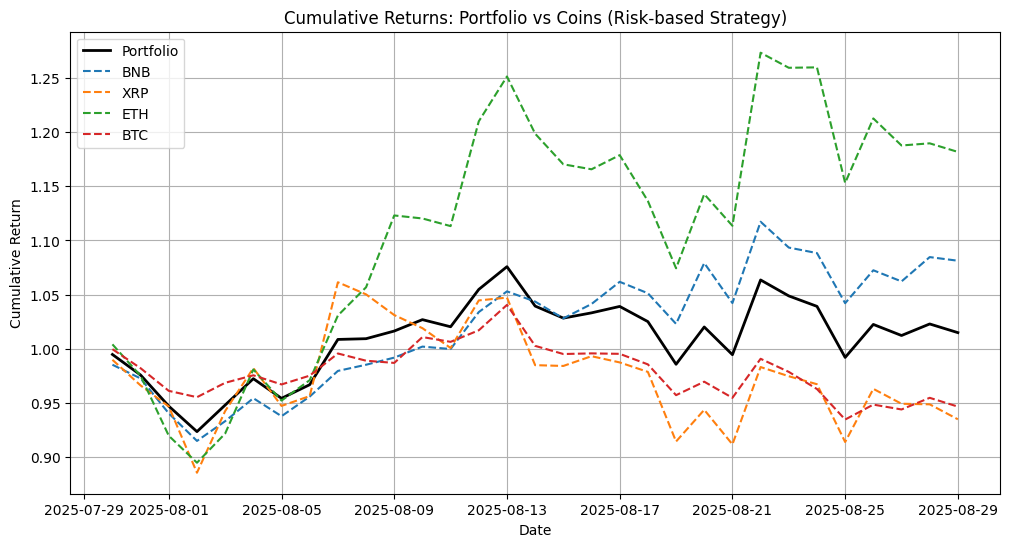

✅ Exported cumulative returns for 'Risk-based' strategy to CSV


In [8]:
import matplotlib.pyplot as plt

# =======================
# 1. Choose strategy
# =======================
# Options: 'Equal', 'Risk-based', 'Market-cap', 'Investment-goal'
selected_strategy = 'Risk-based'  # Change this to plot other strategies

# Get the weights for the chosen strategy
weights = strategies[selected_strategy]
weights = cap_weights(weights)  # Ensure capped weights

# =======================
# 2. Compute cumulative returns for portfolio & individual coins
# =======================
portfolio_cum = (returns @ weights + 1).cumprod()  # portfolio cumulative return

# Individual coin cumulative returns
coin_cum = (returns + 1).cumprod()

# =======================
# 3. Plot line graph
# =======================
plt.figure(figsize=(12,6))
plt.plot(portfolio_cum.index, portfolio_cum, label='Portfolio', linewidth=2, color='black')

for coin in coin_cum.columns:
    plt.plot(coin_cum.index, coin_cum[coin], label=coin, linestyle='--')

plt.title(f"Cumulative Returns: Portfolio vs Coins ({selected_strategy} Strategy)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# =======================
# 4. Export data to CSV
# =======================
output_df = coin_cum.copy()
output_df['Portfolio'] = portfolio_cum
output_df.to_csv(f"cumulative_returns_{selected_strategy}.csv", index=True)
print(f"✅ Exported cumulative returns for '{selected_strategy}' strategy to CSV")


In [12]:
import pandas as pd
import numpy as np
import sqlite3
import smtplib
from email.mime.text import MIMEText

# ===============================
# 📌 Step 1: Email Alert Function
# ===============================
def send_email_alert(to_email, subject, message):
    smtp_server = "smtp.gmail.com"
    smtp_port = 587  # STARTTLS port
    sender_email = "puramvignannavadeepak@gmail.com"
    sender_password = "smjvkwivyrnkrrjb"  # Replace with your App Password

    msg = MIMEText(message, "plain")
    msg["From"] = sender_email
    msg["To"] = to_email
    msg["Subject"] = subject

    try:
        with smtplib.SMTP(smtp_server, smtp_port) as server:
            server.starttls()  # Upgrade connection to secure
            server.login(sender_email, sender_password)
            server.send_message(msg)
        print(f"✅ Email sent successfully to {to_email}")
    except Exception as e:
        print(f"❌ Error sending email: {e}")

# ===============================
# 📌 Step 2: Load & Clean Data
# ===============================
btc = pd.read_csv("BTC_USD Bitfinex Historical Data.csv")
eth = pd.read_csv("Ethereum Historical Data.csv")
bnb = pd.read_csv("BNB Historical Data.csv")
xrp = pd.read_csv("XRP Historical Data.csv")

def clean_df(df, col_name):
    df = df[["Date", "Price"]].copy()
    df["Price"] = df["Price"].astype(str).str.replace(",", "").astype(float)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    df.rename(columns={"Price": col_name}, inplace=True)
    return df

btc = clean_df(btc, "BTC")
eth = clean_df(eth, "ETH")
bnb = clean_df(bnb, "BNB")
xrp = clean_df(xrp, "XRP")

# Merge all assets on Date
df = btc.merge(eth, on="Date").merge(bnb, on="Date").merge(xrp, on="Date")

# ===============================
# 📌 Step 3: Portfolio Returns
# ===============================
weights = np.array([0.25, 0.25, 0.25, 0.25])  # Equal weights
returns = df[["BTC","ETH","BNB","XRP"]].pct_change().dropna()
portfolio_returns = (returns * weights).sum(axis=1)
Rf = 0.0   # Risk-free rate

# ===============================
# 📌 Step 4: Risk Rules with Actual Values
# ===============================
risk_results = {}

# 1. Volatility
volatility = portfolio_returns.std()
risk_results["Volatility"] = volatility
risk_results["Volatility_Rule"] = "PASS" if volatility <= 0.05 else "FAIL"

# 2. Sharpe Ratio
mean_return = portfolio_returns.mean()
sharpe = (mean_return - Rf) / volatility
risk_results["Sharpe"] = sharpe
risk_results["Sharpe_Rule"] = "PASS" if sharpe >= 1 else "FAIL"

# 3. Max Drawdown
cum_returns = (1 + portfolio_returns).cumprod()
running_max = cum_returns.cummax()
drawdown = (cum_returns - running_max) / running_max
mdd = drawdown.min()
risk_results["Max_Drawdown"] = mdd
risk_results["MDD_Rule"] = "PASS" if mdd >= -0.2 else "FAIL"

# 4. Sortino Ratio
downside_returns = portfolio_returns[portfolio_returns < 0]
down_volatility = downside_returns.std()
sortino = (mean_return - Rf) / down_volatility if down_volatility > 0 else np.nan
risk_results["Sortino"] = sortino
risk_results["Sortino_Rule"] = "PASS" if sortino >= 1 else "FAIL"

# 5. Beta (vs BTC as market proxy)
market = returns["BTC"].dropna()
cov = np.cov(portfolio_returns.dropna(), market)[0][1]
beta = cov / market.var()
risk_results["Beta"] = beta
risk_results["Beta_Rule"] = "PASS" if beta <= 1.2 else "FAIL"

# 6. Max Asset Weight
max_weight = max(weights)
risk_results["Max_Weight"] = max_weight
risk_results["Weight_Rule"] = "PASS" if max_weight <= 0.4 else "FAIL"

# Convert to DataFrame
risk_df = pd.DataFrame([risk_results])

# ===============================
# 📌 Step 5: Save into SQLite
# ===============================
conn = sqlite3.connect("portfolio_risk.db")
risk_df.to_sql("risk_results", conn, if_exists="replace", index=False)
conn.close()

print("📊 Risk Metrics & Rule Status")
print(risk_df.T)

# ===============================
# 📌 Step 6: Email Alerts
# ===============================
failed_rules = [rule for rule, status in risk_results.items() if "Rule" in rule and status == "FAIL"]

if failed_rules:
    send_email_alert(
        to_email="puramvignannavadeepak@gmail.com",
        subject="⚠️ Crypto Portfolio Risk Alert",
        message=f"The following rules failed: {', '.join(failed_rules)}"
    )
else:
    print("✅ All rules passed. No alert needed.")


📊 Risk Metrics & Rule Status
                        0
Volatility       0.030895
Volatility_Rule      PASS
Sharpe           0.051231
Sharpe_Rule          FAIL
Max_Drawdown    -0.094924
MDD_Rule             PASS
Sortino          0.110127
Sortino_Rule         FAIL
Beta             1.615398
Beta_Rule            FAIL
Max_Weight           0.25
Weight_Rule          PASS
✅ Email sent successfully to puramvignannavadeepak@gmail.com


In [15]:
# ===============================
# 📌 Step 9: Predict Returns with Linear Regression
# ===============================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

predictions = {}
metrics = {}

def predict_next_return(series, label):
    df_temp = pd.DataFrame(series, columns=[label]).dropna().reset_index(drop=True)
    df_temp["Lag1"] = df_temp[label].shift(1)
    df_temp = df_temp.dropna()

    X = df_temp[["Lag1"]]
    y = df_temp[label]

    model = LinearRegression()
    model.fit(X, y)

    last_value = series.iloc[-1]
    predicted = model.predict(pd.DataFrame([[last_value]], columns=["Lag1"]))[0]

    # Metrics
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return predicted, mse, r2

# Individual assets
for asset in ["BTC", "ETH", "BNB", "XRP"]:
    pred, mse, r2 = predict_next_return(returns[asset], asset)
    predictions[f"{asset}_Pred"] = pred
    metrics[asset] = {"MSE": mse, "R2": r2}

# Portfolio
pred_port, mse_port, r2_port = predict_next_return(portfolio_returns, "Portfolio")
predictions["Portfolio_Pred"] = pred_port
metrics["Portfolio"] = {"MSE": mse_port, "R2": r2_port}

# ===============================
# 📌 Step 10: Show Results
# ===============================
print("\n📈 Predicted Next-Day Returns:")
for k, v in predictions.items():
    print(f"{k}: {v:.4%}")

print("\n📊 Historical Fit Metrics:")
for asset, vals in metrics.items():
    print(f"{asset}: MSE={vals['MSE']:.6f}, R²={vals['R2']:.4f}")

# ===============================
# 📌 Step 11: Save Predictions in SQLite
# ===============================
conn = sqlite3.connect("portfolio_risk.db")
pred_df = pd.DataFrame([predictions])
pred_df.to_sql("return_predictions", conn, if_exists="append", index=False)
conn.close()



📈 Predicted Next-Day Returns:
BTC_Pred: -0.0467%
ETH_Pred: 0.8089%
BNB_Pred: 0.5569%
XRP_Pred: 0.1845%
Portfolio_Pred: 0.3900%

📊 Historical Fit Metrics:
BTC: MSE=0.000282, R²=0.0286
ETH: MSE=0.002288, R²=0.0123
BNB: MSE=0.000595, R²=0.1211
XRP: MSE=0.001597, R²=0.0458
Portfolio: MSE=0.000913, R²=0.0422


In [16]:
# --- Data Preparation ---
def prepare_data(df, name):
    if "Change %" in df.columns:
        df["Return"] = df["Change %"].str.replace("%", "", regex=True).astype(float) / 100
    elif "Price" in df.columns:
        df["Return"] = df["Price"].pct_change()
    else:
        raise ValueError(f"No usable column in {name}")
    df = df[["Date", "Return"]].rename(columns={"Return": name})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.dropna().reset_index(drop=True)
    return df

# --- Risk Parity Rule ---
def risk_parity_rule(returns_window: pd.DataFrame):
    vols = returns_window.std(ddof=0)
    vols = vols.replace(0, np.nan)
    inv_vols = 1 / (vols + 1e-8)
    weights = inv_vols / inv_vols.sum()
    return weights.fillna(1 / len(vols))  # fallback if any column missing

# --- Dynamic Weight Calculation ---
def calculate_dynamic_weights(returns: pd.DataFrame, window=30):
    weights_list = []
    for i in range(len(returns)):
        # dynamically adapt window for early days
        start_idx = max(0, i - window)
        window_data = returns.iloc[start_idx:i+1]  # include current day
        weights = risk_parity_rule(window_data)
        weights_list.append(weights.values)
    weights_df = pd.DataFrame(weights_list, columns=returns.columns)
    return weights_df

# --- Portfolio Return Calculation ---
def calculate_portfolio_returns(returns: pd.DataFrame, weights: pd.DataFrame):
    weighted_returns = returns * weights
    portfolio = weighted_returns.sum(axis=1)
    return weighted_returns, portfolio

# --- Main Pipeline ---
def run_risk_parity_pipeline(window=30):
    # Read uploaded CSVs
    btc = pd.read_csv("BTC_USD Bitfinex Historical Data.csv")
    eth = pd.read_csv("Ethereum Historical Data.csv")
    bnb = pd.read_csv("BNB Historical Data.csv")
    xrp = pd.read_csv("XRP Historical Data.csv")

    # Prepare data
    btc = prepare_data(btc, "BTC")
    eth = prepare_data(eth, "ETH")
    bnb = prepare_data(bnb, "BNB")
    xrp = prepare_data(xrp, "XRP")

    # Merge on Date
    returns = btc.merge(eth, on="Date").merge(bnb, on="Date").merge(xrp, on="Date")
    returns = returns.sort_values("Date").reset_index(drop=True)
    return_data = returns.drop(columns=["Date"])

    # Compute dynamic risk parity weights (for every day)
    weights_df = calculate_dynamic_weights(return_data, window)
    print(f"📊 Calculated TRUE Risk Parity Weights (dynamic daily, window={window})")

    # Compute portfolio returns
    weighted_returns, portfolio = calculate_portfolio_returns(return_data, weights_df)

    # Combine all outputs
    df_out = pd.concat([
        returns["Date"],
        return_data,
        weights_df.add_suffix("_Weight"),
        portfolio.rename("Portfolio")
    ], axis=1)

    # Save to SQLite database
    conn = sqlite3.connect("crypto_portfolio.db")
    df_out.to_sql("RiskParityResults", conn, if_exists="replace", index=False)
    conn.close()

    print("✅ Stored True Dynamic Risk Parity Portfolio in DB")
    return df_out

# --- Run ---
if __name__ == "__main__":
    df = run_risk_parity_pipeline(window=30)
    print(df.head(20))
    print(df.tail(10))


📊 Calculated TRUE Risk Parity Weights (dynamic daily, window=30)
✅ Stored True Dynamic Risk Parity Portfolio in DB
         Date     BTC     ETH     BNB     XRP  BTC_Weight  ETH_Weight  \
0  2025-07-29 -0.0006 -0.0008 -0.0226  0.0019    0.250000    0.250000   
1  2025-07-30 -0.0005  0.0039 -0.0149 -0.0103    0.959261    0.020414   
2  2025-07-31 -0.0176 -0.0290 -0.0129 -0.0240    0.236126    0.130630   
3  2025-08-01 -0.0213 -0.0568 -0.0332 -0.0202    0.282483    0.110639   
4  2025-08-02 -0.0061 -0.0271 -0.0271 -0.0646    0.341190    0.134911   
5  2025-08-03  0.0139  0.0302  0.0200  0.0644    0.415859    0.174371   
6  2025-08-04  0.0072  0.0642  0.0228  0.0421    0.460825    0.143881   
7  2025-08-05 -0.0087 -0.0293 -0.0174 -0.0356    0.463683    0.141932   
8  2025-08-06  0.0084  0.0198  0.0193  0.0096    0.463066    0.147635   
9  2025-08-07  0.0210  0.0615  0.0248  0.1100    0.459294    0.152763   
10 2025-08-08 -0.0067  0.0253  0.0058 -0.0105    0.459072    0.152172   
11 2025-0

In [19]:
# ===============================
# 📌 Stress Test with Risk Parity Weights
# ===============================
import pandas as pd
import numpy as np
import sqlite3

# --- Connect to DB ---
db_name = "crypto_portfolio.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

# --- Check if the table exists ---
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='DynamicRiskParityResults';")
table_exists = cursor.fetchone() is not None



# --- Extract asset returns only ---
assets = ["BTC", "ETH", "BNB", "XRP"]
returns = df[assets].dropna()

# --- Compute Risk Parity Weights ---
vols = returns.std()
inv_vols = 1 / vols
weights = inv_vols / inv_vols.sum()

print("\n📊 Risk Parity Weights:")
for asset, w in zip(assets, weights):
    print(f"{asset}: {w:.4f}")

# --- Stress Test Scenarios ---
def stress_test(weights):
    scenarios = {
        "Bull": pd.DataFrame({
            "BTC": [0.05, 0.04, 0.03, 0.06],
            "ETH": [0.04, 0.03, 0.02, 0.05],
            "BNB": [0.03, 0.02, 0.01, 0.04],
            "XRP": [0.02, 0.015, 0.01, 0.03]
        }),
        "Bear": pd.DataFrame({
            "BTC": [-0.05, -0.04, -0.03, -0.06],
            "ETH": [-0.04, -0.03, -0.02, -0.05],
            "BNB": [-0.03, -0.02, -0.01, -0.04],
            "XRP": [-0.02, -0.015, -0.01, -0.03]
        }),
        "Volatile": pd.DataFrame({
            "BTC": [0.10, -0.10, 0.12, -0.08],
            "ETH": [0.08, -0.07, 0.09, -0.06],
            "BNB": [0.07, -0.05, 0.06, -0.04],
            "XRP": [0.06, -0.04, 0.05, -0.03]
        })
    }

    results = {}
    for name, scen in scenarios.items():
        scen_portfolio = scen.mul(weights, axis=1).sum(axis=1)
        results[name] = scen_portfolio
    return results

# --- Run Stress Test ---
stress_results = stress_test(weights)

# --- Print Results ---
print("\n📊 Stress Test Results:")
for scenario, scen_returns in stress_results.items():
    print(f"\n🔹 {scenario} Market Portfolio Returns:")
    print(np.round(scen_returns.values, 4))

# --- Insights ---
print("\n📈 Insights:")
print("- In Bull market → portfolio grows steadily, all assets contribute to gains.")
print("- In Bear market → portfolio declines, but risk parity avoids concentration of losses.")
print("- In Volatile market → portfolio absorbs swings more smoothly than any single coin.")



📊 Risk Parity Weights:
BTC: 0.3440
ETH: 0.2620
BNB: 0.1921
XRP: 0.2019

📊 Stress Test Results:

🔹 Bull Market Portfolio Returns:
[0.0375 0.0285 0.0195 0.0475]

🔹 Bear Market Portfolio Returns:
[-0.0375 -0.0285 -0.0195 -0.0475]

🔹 Volatile Market Portfolio Returns:
[ 0.0809 -0.0704  0.0865 -0.057 ]

📈 Insights:
- In Bull market → portfolio grows steadily, all assets contribute to gains.
- In Bear market → portfolio declines, but risk parity avoids concentration of losses.
- In Volatile market → portfolio absorbs swings more smoothly than any single coin.
